# Final Model
This notebook contains the code used to train our FER state-of-the-art model, result visulization, and some tests.

### Setup

In [1]:
from fastbook import *
from fastai.vision.all import *
import pandas as pd
from PIL import Image
import numpy

def _plot_top_losses(self, k, largest=True, **kwargs):
    losses,idx = self.top_losses(k, largest)
    if not isinstance(self.inputs, tuple): self.inputs = (self.inputs,)
    if isinstance(self.inputs[0], Tensor): inps = tuple(o[idx] for o in self.inputs)
    else: inps = self.dl.create_batch(self.dl.before_batch([tuple(o[i] for o in self.inputs) for i in idx]))
    b = inps + tuple(o[idx] for o in (self.targs if is_listy(self.targs) else (self.targs,)))
    x,y,its = self.dl._pre_show_batch(b, max_n=k)
    b_out = inps + tuple(o[idx] for o in (self.decoded if is_listy(self.decoded) else (self.decoded,)))
    x1,y1,outs = self.dl._pre_show_batch(b_out, max_n=k)
    if its is not None:
        plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), self.preds[idx], losses, **kwargs)
ClassificationInterpretation.plot_top_losses = _plot_top_losses

In [3]:
path = '/home/cp47/CS344FinalProject/data/'
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
df = pd.read_csv(path + 'icml_face_data.csv')

In [4]:
def get_x(data): 
    images = np.fromstring(data[' pixels'], dtype=int, sep=' ')
    images = np.reshape(images, (48, 48)).astype(np.uint8)
    return images
def get_y(data): return emotions[data['emotion']]
def splitter(data):
    train = data.index[data[' Usage'] == 'Training'].tolist()
    valid = data.index[data[' Usage'] != 'Training'].tolist()
    return train, valid

All images are scaled up from 48 by 48 pixels to 160 by 160 pixels, using fast.ai's data augmentation function.

In [4]:
dblock = DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                   get_x = get_x,
                   get_y = get_y,
                   splitter=splitter,
                   batch_tfms=aug_transforms(size=(160,160))
                  )
dls = dblock.dataloaders(df)

/opt/anaconda/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


### Model Training

Our model is fine tuned on VGG_16 architecture.

In [5]:
learn = cnn_learner(dls, vgg16_bn, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

Get a suggested learning rate using fast.ai's lr_find method.

SuggestedLRs(valley=0.0012022644514217973)

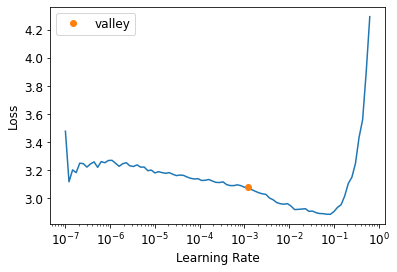

In [6]:
learn.lr_find()

Run 30 epochs with LR=0.0012.

In [7]:
learn.fine_tune(30, 0.0012)

epoch,train_loss,valid_loss,accuracy,time
0,1.878061,1.549697,0.431039,02:55


epoch,train_loss,valid_loss,accuracy,time
0,1.467113,1.260140,0.525913,03:49
1,1.252795,1.134013,0.572165,03:50
2,1.166259,1.044554,0.606018,03:50
3,1.052309,0.985691,0.630816,03:52
4,0.972653,0.951034,0.645166,03:50
5,0.916265,0.926566,0.657425,03:53
6,0.862974,0.911865,0.667177,03:50
7,0.815135,0.917995,0.670660,03:51
8,0.759205,0.908421,0.680412,03:50
9,0.682875,0.926987,0.682502,03:51


In [7]:
learn.fine_tune(30, 0.0012)

epoch,train_loss,valid_loss,accuracy,time
0,1.070938,1.051474,0.606018,02:57


epoch,train_loss,valid_loss,accuracy,time
0,0.999811,0.990160,0.626916,03:52
1,0.960232,0.957430,0.638061,03:50
2,0.920694,0.942778,0.648370,03:50
3,0.875522,0.921290,0.663695,03:50
4,0.855947,0.919677,0.660908,03:50
5,0.826706,0.909128,0.668710,03:50
6,0.765433,0.910539,0.676651,03:52
7,0.726749,0.929780,0.674840,03:52
8,0.693548,0.932522,0.675954,03:50
9,0.618212,0.950810,0.680970,03:50


Repeat the previous process and run for another 10 epochs.

SuggestedLRs(valley=3.311311274956097e-06)

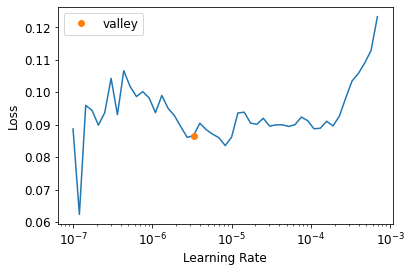

In [8]:
learn.lr_find()

In [9]:
learn.fine_tune(10, 3e-04)

epoch,train_loss,valid_loss,accuracy,time
0,0.097091,1.558044,0.702703,02:57


epoch,train_loss,valid_loss,accuracy,time
0,0.092669,1.574281,0.699777,03:53
1,0.111244,1.615466,0.700195,03:51
2,0.121991,1.590259,0.702145,03:54
3,0.111573,1.600133,0.700056,03:54
4,0.117636,1.618991,0.701031,03:53
5,0.094101,1.618146,0.702981,03:54
6,0.085165,1.616942,0.704096,03:51
7,0.078886,1.642210,0.702703,03:50
8,0.073738,1.619288,0.704792,03:49
9,0.076890,1.633251,0.703817,03:52


**Our goal of 70% accuracy rate is reached.**

### Visualization of the result

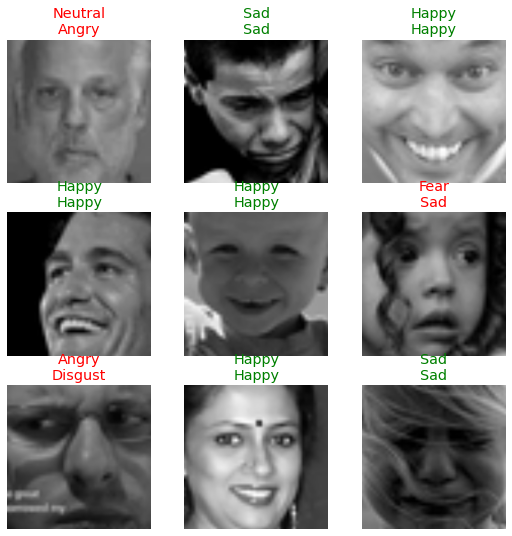

In [8]:
learn.show_results()

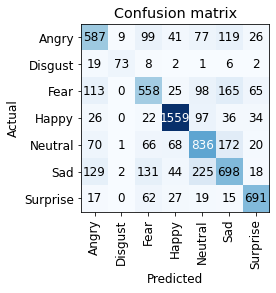

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

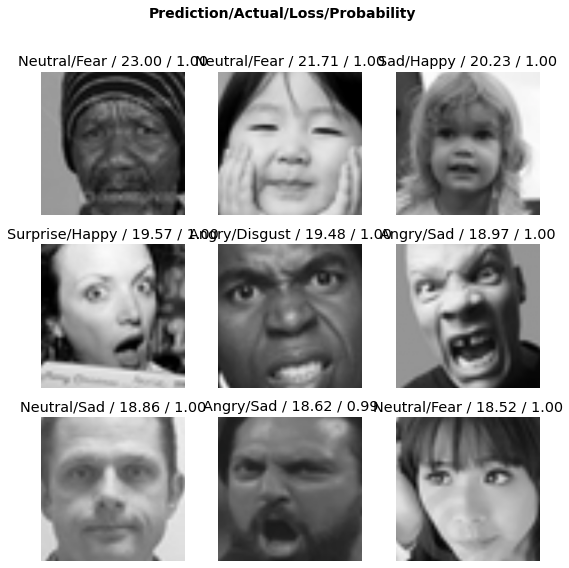

In [10]:
interp.plot_top_losses(k=9)

### Tests with our own photos

In [11]:
learn.save('final')
learn.export(fname='FinalModel.pkl')

In [5]:
mod = load_learner('/home/cp47/CS344FinalProject/FinalModel.pkl')

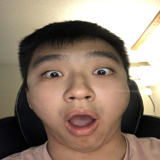

In [6]:
test1 = Image.open('test/test1.jpg').resize((160,160)).rotate(-90)
test1

In [7]:
mod.predict(numpy.array(test1))

('Surprise',
 TensorBase(6),
 TensorBase([1.0758e-06, 3.5298e-08, 2.2534e-01, 3.0611e-03, 4.1751e-04, 7.5513e-02, 6.9566e-01]))

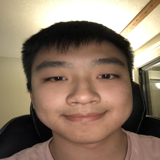

In [8]:
test2 = Image.open('test/test2.jpg').resize((160,160)).rotate(-90)
test2

In [9]:
mod.predict(numpy.array(test2))

('Happy',
 TensorBase(3),
 TensorBase([1.3568e-06, 3.0624e-07, 1.5960e-03, 9.6894e-01, 1.6995e-03, 1.6086e-02, 1.1677e-02]))

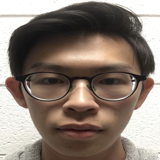

In [10]:
test3 = Image.open('test/test3.jpg').resize((160,160))
test3

In [11]:
mod.predict(numpy.array(test3))

('Neutral',
 TensorBase(4),
 TensorBase([4.6171e-02, 2.3268e-06, 2.0386e-04, 1.3104e-01, 8.0103e-01, 2.1548e-02, 3.0099e-06]))